In [1]:
'''
1. ニューラルネットワークの定義
'''
import numpy as np

class neuralNetwork:
    '''ニューラルネットワークを生成する
    
    Attributes:
      input(int)(int) : 入力層のニューロン数
      fc1(int): 隠れ層のニューロン数
      fc2(int): 出力層のニューロン数
      lr(float): 学習率
      w1(array): 隠れ層のバイアス、重み行列
      w2(array): 出力層のバイアス、重み行列
    '''
    
    def __init__(self, input_dim, hidden_dim, output_dim, learning_rate):
        '''ニューラルネットワークの初期化を行う
        
        Parameters:
          input_dim(int) : 入力層のニューロン数
          hidden_dim(int): 隠れ層のニューロン数
          output_dim(int): 出力層のニューロン数
          learning_rate(float): 学習率

        '''
        # 入力層、隠れ層、出力層のニューロン数をインスタンス変数に代入
        self.input = input_dim    # 入力層のニューロン数
        self.fc1 = hidden_dim     # 隠れ層のニューロン数
        self.fc2 = output_dim     # 出力層のニューロン数
        self.lr = learning_rate   # 学習率
        self.weight_initializer() # weight_initializer()を呼ぶ

    def weight_initializer(self):
        '''重みとバイアスの初期化を行う
        
        '''
        # 隠れ層の重みとバイアス
        # (隠れ層のニューロン数
        self.w1 = np.random.normal(
            0.0,                   # 平均は0
            pow(self.input, -0.5), # 標準偏差は入力層のデータサイズを元に計算
            (self.fc1,             # 行数は隠れ層のニューロン数
             self.input + 1)       # 列数は入力層のデータサイズ + 1
            )
        
       # 出力層の重みとバイアスを初期化
        self.w2 = np.random.normal(
            0.0,                 # 平均は0
            pow(self.fc1, -0.5), # 標準偏差は隠れ層のニューロン数を元に計算
            (self.fc2,           # 行数は出力層のニューロン数
             self.fc1 + 1)       # 列数は隠れ層のニューロン数 + 1
            )
    
    def sigmoid(self, x):
        '''シグモイド関数
        
        Parameters:
          x(array): 関数を適用するデータ
        '''
        return 1 / (1 + np.exp(-x))

    def softmax(self, x):
        '''ソフトマックス関数
        
        Parameters:
          x(array): 関数を適用するデータ
        '''
        c = np.max(x)
        exp_x = np.exp(x - c) # オーバーフロー対策
        sum_exp_x = np.sum(exp_x)
        y = exp_x / sum_exp_x
        return y
    
    def train(self, train_x, train_y):
        '''ニューラルネットワークの学習を行う
        
        Parameters：
          train_x(array): 訓練データ
          train_y(array): 正解ラベル
        '''
        ## [入力層]
        # 入力値の配列にバイアス項を追加して入力層から出力する
        inputs = np.array(
            np.append(train_x, [1]), # 配列の末尾にバイアスのための「1」を追加
            ndmin=2                  # 2次元化
            ).T                      # 転置して1列の行列にする

        ## [隠れ層]
        # 入力層の出力に重み、バイアスを適用して隠れ層に入力する
        hidden_inputs = np.dot(
            self.w1, # 隠れ層の重み
            inputs   # 入力層の出力
            )
        # シグモイド関数を適用して隠れ層から出力
        hidden_outputs = self.sigmoid(hidden_inputs)      
        # 隠れ層の出力行列の末尾にバイアスのための「1」を追加
        hidden_outputs = np.append(
            hidden_outputs, # 隠れ層の出力行列
            [[1]],          # 2次元形式でバイアス値を追加
            axis=0          # 行を指定(列は1)
            )
        
        ## [出力層]
        # 出力層への入力信号を作る
        final_inputs = np.dot(
            self.w2,       # 隠れ層と出力層の間の重み
            hidden_outputs # 隠れ層の出力
            )
        # ソフトマックス関数を適用して出力層から出力する
        final_outputs = self.softmax(final_inputs)

        ## ---バックプロパゲーション---(出力層)
        # 正解ラベルの配列を1列の行列に変換する
        targets = np.array(
            train_y,        # 正解ラベルの配列
            ndmin=2              # 2次元化
            ).T                  # 転置して1列の行列にする
        # 出力値と正解ラベルとの誤差
        output_errors = final_outputs - targets
        # 出力層の入力誤差δを求める
        delta_output = output_errors*(1 - final_outputs)*final_outputs
        # 重みを更新する前に隠れ層の出力誤差を求めておく
        hidden_errors = np.dot(
            self.w2.T,           # 出力層の重み行列を転置する
            delta_output         # 出力層の入力誤差δ
            )
        # 出力層の重み、バイアスの更新
        self.w2 -= self.lr * np.dot(
            # 出力誤差＊(1－出力信号)＊出力信号 
            delta_output,
            # 隠れ層の出力行列を転置
            hidden_outputs.T
        )

        ## ---バックプロパゲーション---(隠れ層)
        # 逆伝搬された隠れ層の出力誤差からバイアスのものを取り除く
        hidden_errors_nobias = np.delete(
            hidden_errors,  # 隠れ層のエラーの行列
            self.fc1, # 隠れ層のニューロン数をインデックスにして末尾要素を削除
            axis=0    # 行の削除を指定
            )
        # 隠れ層の出力行列からバイアスを除く
        hidden_outputs_nobias = np.delete(
            hidden_outputs, # 隠れ層の出力の行列
            self.fc1, # 隠れ層のニューロン数をインデックスにして末尾要素を削除
            axis=0    # 行の削除を指定
            )
        # 隠れ層の重み、バイアスの更新
        self.w1 -= self.lr * np.dot(
            # 逆伝搬された隠れ層の出力誤差＊(1－隠れ層の出力)＊隠れ層の出力 
            hidden_errors_nobias*(
                1.0 - hidden_outputs_nobias
            )*hidden_outputs_nobias,
            # 入力層の出力信号の行列を転置
            inputs.T
            )
                
    def evaluate(self, inputs_list):
        '''学習した重みでテストデータを評価する
        
        Parameters:
          inputs_list(array): テスト用データ
        Returns:
          array: モデルからの出力
        '''
        ## [入力層]
        # 入力値の配列にバイアス項を追加して入力層から出力する
        inputs = np.array(
            np.append(inputs_list, [1]), # 配列の末尾にバイアスの「1」を追加
            ndmin=2                      # 2次元化
        ).T                              # 転置して1列の行列にする
        
        ## [隠れ層]
        # 入力層の出力に重み、バイアスを適用して隠れ層に入力する
        hidden_inputs = np.dot(self.w1,  # 入力層と隠れ層の間の重み
                               inputs    # テストデータの行列
                              )       
        # 活性化関数を適用して隠れ層から出力する
        hidden_outputs = self.sigmoid(hidden_inputs)
        
        ## [出力層]
        # 出力層への入力信号を計算
        final_inputs = np.dot(
            self.w2,                        # 隠れ層と出力層の間の重み
            np.append(hidden_outputs, [1]), # 隠れ層の出力配列の末尾にバイアスの「1」を追加
            )       
        # 活性化関数を適用して出力層から出力する
        final_outputs = self.softmax(final_inputs)
        
        # 出力層からの出力を戻り値として返す
        return final_outputs

In [2]:
'''
2. Fashion-MNISTを読み込んで前処理を行う
'''
from tensorflow.keras.datasets import fashion_mnist
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

# (60000,28,28)の3階テンソルを(60000,784)の2階テンソルに変換
x_train = x_train.reshape(60000, 784)
# データを255で割って0.99を掛けた後、0.01を加えてシフトする
x_train = (x_train / 255.0 * 0.99) + 0.01

In [3]:
%%time
'''
3. 学習を行う
'''
input_neurons = 784    # 入力層のニューロンの数
hidden_neuronss = 256  # 隠れ層のニューロンの数
output_neurons = 10    # 出力層のニューロンの数
learning_rate = 0.1    # 学習率

# neuralNetworkクラスのインスタンス化
n = neuralNetwork(input_neurons,
                  hidden_neuronss,
                  output_neurons,
                  learning_rate)

# ニューラルネットワークの学習
epochs = 10            # 学習を繰り返す回数

# 指定した回数だけ学習を繰り返す
for e in range(epochs):
    # 画像データと正解ラベルを1セットずつ取り出す
    for (x, y) in zip(x_train, y_train):
        # 出力層のニューロン数を要素数とするOne-hotベクトルを作成
        target = np.zeros(output_neurons) + 0.01
        # 正解ラベルに対応する要素を0.99にする
        target[int(y)] = 0.99
        # 画像データと正解ラベルの1セットを引数にしてtrain()を実行
        n.train(x,       # 訓練データ
                target ) # 正解ラベル
    # 学習が1回終了する毎に出力
    print('Completed:', e+1)

Completed: 1
Completed: 2
Completed: 3
Completed: 4
Completed: 5
Completed: 6
Completed: 7
Completed: 8
Completed: 9
Completed: 10
Wall time: 34min 13s


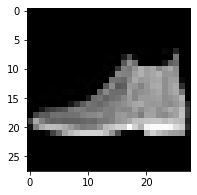

9


In [4]:
'''
4. テストデータの画像と正解ラベルを出力
'''
import matplotlib.pyplot as plt
%matplotlib inline

plt.ﬁgure(ﬁgsize=(3, 3)) # サイズを3×3にする
plt.gray()               # グレースケールにする
plt.imshow(x_test[0])   # 画像をプロットする
plt.show()
print(y_test[0])        # 1番目の正解ラベルを出力

In [5]:
'''
5. 学習済みモデルの検証
'''
# 画像データのフラット化
# (10000,28,28)の3階テンソルを(10000,784)の2階テンソルに変換
x_test = x_test.reshape(10000, 784)
# データを255で割って0.99を掛けた後、0.01を加えてシフトする
x_test = (x_test / 255.0 * 0.99) + 0.01
# 正解は1、不正解は0を格納するリスト
score = []

# x_test、y_testから1データ抽出してx、yに格納
for (x, y) in zip(x_test, y_test):
    # 学習済みのモデルで評価する
    outputs = n.evaluate(x)
    # 出力層のニューロン数に合わせて正解の配列を作成
    targets = np.zeros(output_neurons) + 0.01
    # 正解値に対応する要素を0.99にする
    targets[int(y)] = 0.99
    # 出力の行列の最大値のインデックスが予測するアイテムに対応
    label = np.argmax(outputs)
    # ネットワークの出力と正解ラベルを比較
    if (label == y):
        score.append(1) # 正解ならscoreに1を追加
    else:
        score.append(0) # 不正解なら0を追加

In [6]:
'''
6. 正誤記録を出力する
'''
result = ['〇' if i  == 1 else '●' for i in score]
print(result)

['〇', '〇', '〇', '〇', '〇', '〇', '〇', '〇', '〇', '〇', '〇', '〇', '〇', '〇', '〇', '〇', '〇', '●', '〇', '〇', '〇', '〇', '〇', '●', '〇', '●', '〇', '〇', '〇', '〇', '〇', '〇', '〇', '〇', '〇', '〇', '〇', '〇', '〇', '〇', '●', '〇', '〇', '〇', '〇', '〇', '〇', '〇', '〇', '●', '〇', '●', '〇', '〇', '〇', '〇', '〇', '〇', '〇', '〇', '〇', '〇', '〇', '〇', '〇', '〇', '●', '〇', '●', '〇', '〇', '〇', '〇', '●', '〇', '〇', '〇', '〇', '〇', '〇', '〇', '〇', '〇', '〇', '〇', '〇', '〇', '〇', '〇', '●', '〇', '〇', '〇', '〇', '〇', '〇', '〇', '〇', '〇', '〇', '〇', '〇', '〇', '〇', '〇', '〇', '〇', '●', '〇', '〇', '〇', '〇', '〇', '〇', '〇', '〇', '〇', '●', '〇', '〇', '〇', '〇', '〇', '〇', '〇', '〇', '〇', '●', '〇', '〇', '〇', '〇', '〇', '〇', '〇', '●', '●', '〇', '〇', '〇', '〇', '●', '〇', '〇', '〇', '〇', '〇', '●', '〇', '〇', '●', '●', '〇', '●', '〇', '〇', '〇', '〇', '〇', '〇', '〇', '〇', '〇', '〇', '〇', '〇', '〇', '〇', '〇', '〇', '〇', '〇', '●', '〇', '〇', '〇', '〇', '〇', '〇', '〇', '〇', '〇', '〇', '●', '〇', '〇', '〇', '〇', '〇', '〇', '〇', '〇', '〇', '〇', '〇', '〇', '〇', '〇', '〇', '〇',

In [7]:
'''
7. 精度を求める
'''
# 配列scoreをNumPy配列に変換
score_arry = np.asarray(score)
# score_arryの合計をscore_arryの要素数で割って精度を求める 
print ("performance = ",
       score_arry.sum() / score_arry.size)

performance =  0.8657
